 # <div align="center">Kaggle Solution: What’s Cooking ? (Text Mining Competition)</div>
---------------------------------------------------------------------

you can Find me on Github:
> ###### [ GitHub](https://github.com/lev1khachatryan)
  
  
<img src="pics_for_py/1.jpg" />


<a id="1"></a> <br>

# <div align="center">1. Introduction</div>
---------------------------------------------------------------------
[go to top](#top)

This Kaggle competition asks us to predict the category of a dish's cuisine given a list of its ingredients. The dataset is provided by Yummly.  
  
This notebook provides a step-by-step analysis and solution to the given problem. It can also serve as a great starting point for learning how to explore, manipulate, transform and learn from textual data. It is divided into three main sections:
* Exploratory Analysis - as a first step, we explore the main characteristics of the data with the help of Plotly vizualizations;
* Text Processing - here we apply some basic text processing techniques in order to clean and prepare the data for model development;
* Feature Engineering & Data Modeling - in this section we extract features from data and build a predictive model of the cuisine. 

# <div align="center">I.What's Cooking? - Exploratory Analysis</div>
---------------------------------------------------------------------

1) Load necessary libraries

In [1]:
# Data processing 
import pandas as pd
import json
from collections import Counter
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re

# Data vizualizations
import random
import plotly
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
init_notebook_mode(connected=True)
import plotly.offline as offline
import plotly.graph_objs as go
from matplotlib import pyplot as plt

# Data Modeling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn import model_selection 
import warnings
warnings.filterwarnings('ignore')

2) Import json files with train and test samples 

In [2]:
'''
Load data as DataFrame for modelbuilding
'''
train_data  = pd.read_json("data/train.json")
test_data  = pd.read_json("data/test.json")

'''
Load Data as list f json files for data visualization
'''
with open('data/train.json') as data_file:    
    train = json.load(data_file)
with open('data/test.json') as data_file:    
    test = json.load(data_file)

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [4]:
train_data.shape # 39774 observations, 3 columns

(39774, 3)

In [5]:
print("The training data consists of {} recipes".format(len(train_data)))

The training data consists of 39774 recipes


In [6]:
print("First five elements in our training sample:")
train_data.head()

First five elements in our training sample:


,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


Take a quick look on test sample also:

In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 2 columns):
id             9944 non-null int64
ingredients    9944 non-null object
dtypes: int64(1), object(1)
memory usage: 155.5+ KB


In [8]:
test_data.shape # 9944 observations, 2 columns

(9944, 2)

In [9]:
print("The test data consists of {} recipes".format(len(test_data)))

The test data consists of 9944 recipes


In [10]:
print("First five elements in our test sample:")
test_data.head()

First five elements in our test sample:


,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


The test and train data provided in this Kaggle competition are in json format. We have imported the data as a data frame object and the above lines of code show us the initial look of both samples. We observe that each recipe is a separate row and has:

* a unique identifier - the 'id' column;
* the type of cuisine in which this recipe falls - this is our target variable (the test sample does not have this column);
* a list object with ingredients (the recipe) - this will be the main source of explanatory variables in our classification problem.

Problem statement: Predict the type of cuisine based on given data (ingredients). This is a classification task which requires text processing and analysis.

3) Now let's explore a little bit more the target variable

In [11]:
print("Number of cuisine categories: {}".format(len(train_data.cuisine.unique())))
train_data.cuisine.unique()

Number of cuisine categories: 20


array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

There are 20 different categories (cuisines) which we are going to predict. 
This means that the problem at hand is a multi-class classification (there are more than 2 categories to predict). 

Define a function for generating colours at random - it will be used for vizualizations in the analysis

In [12]:
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

Create a table giving information on the number of times each cuisine is represented in the training sample 

In [13]:
trace = go.Table(
                header=dict(values=['Cuisine','Number of recipes'],
                fill = dict(color=['#EABEB0']), 
                align = ['left'] * 5),
                cells=dict(values=[train_data.cuisine.value_counts().index,train_data.cuisine.value_counts()],
               align = ['left'] * 5))

layout = go.Layout(title='Number of recipes in each cuisine category',
                   titlefont = dict(size = 20),
                   width=500, height=650, 
                   paper_bgcolor =  'rgba(0,0,0,0)',
                   plot_bgcolor = 'rgba(0,0,0,0)',
                   autosize = False,
                   margin=dict(l=30,r=30,b=1,t=50,pad=1),
                   )
data = [trace]
fig = dict(data=data, layout=layout)
iplot(fig)

Total number of recipes: 39774


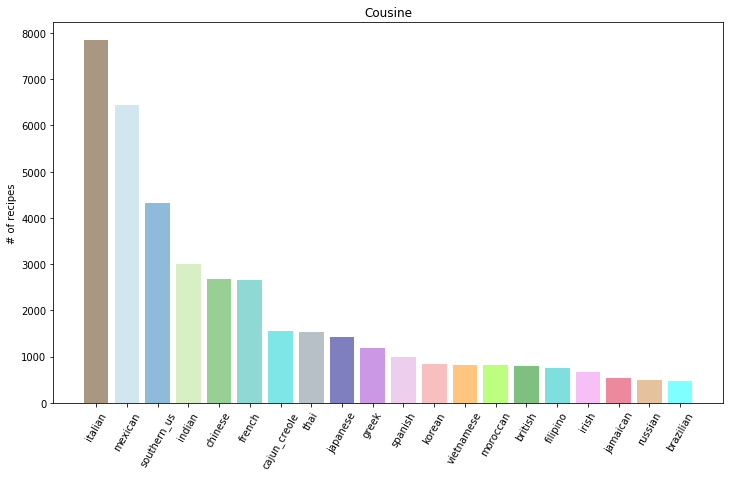

In [14]:
'''
Print Total number of receipes
'''
print('Total number of recipes: %d' % len(train))

'''
Collect all cousines per reseipes
'''
cousine_map = {}
for recipe in train:
    cousine_name = recipe['cuisine']
    recipe_count = cousine_map.get(cousine_name, 0)
    cousine_map[cousine_name] = recipe_count+1

'''
get a sorted (by number of recipes) list of cousines
''' 
cousines = sorted(list(cousine_map.items()), key=lambda tup: -tup[1])       

'''
Draw cousines barchart
'''
names = [c[0] for c in cousines]
values = [c[1] for c in cousines]

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size

index = np.arange(len(names))
bars = plt.bar(index, values, align='center', alpha=0.5, 
           color=['#543005', '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c',
                 'lightseagreen', 'darkturquoise', 'slategray', 'navy', 'darkorchid',
                 'plum', 'lightcoral', 'darkorange', 'lawngreen', 'g',
                 'c', 'violet', 'crimson', 'peru', 'aqua'])

plt.xticks(index, names, fontsize=10, rotation=60)
plt.ylabel('# of recipes')
plt.title('Cousine')

plt.savefig('pics/Cousine.png')
plt.show()

In [15]:
'''
Total number ingredients in train dataset
'''

all_ingredients_train = {}
for recipe in train:
    ingredients = recipe['ingredients']
    for ing_name in ingredients:
        ing_count = all_ingredients_train.get(ing_name.lower(), 0)
        all_ingredients_train[ing_name.lower()] = ing_count+1

print("Total ingredients in train dataset: %d" % len(all_ingredients_train))

Total ingredients in train dataset: 6703


Create also a plot with label distribution 

In [16]:
#  Label distribution in percents
labelpercents = []
for i in train_data.cuisine.value_counts():
    percent = (i/sum(train_data.cuisine.value_counts()))*100
    percent = "%.2f" % percent
    percent = str(percent + '%')
    labelpercents.append(percent)

In [17]:
trace = go.Bar(
            x=train_data.cuisine.value_counts().values[::-1],
            y= [i for i in train_data.cuisine.value_counts().index][::-1],
            text =labelpercents[::-1],  textposition = 'outside', 
            orientation = 'h',marker = dict(color = random_colours(20)))
layout = go.Layout(title='Number of recipes in each cuisine category',
                   titlefont = dict(size = 25),
                   width=1000, height=450, 
                   plot_bgcolor = 'rgba(0,0,0,0)',
                   paper_bgcolor = 'rgba(255, 219, 227, 0.88)',
                   margin=dict(l=75,r=110,b=50,t=60),
                   )
data = [trace]
fig = dict(data=data, layout=layout)
iplot(fig, filename='horizontal-bar')

From the table and the plot of label distribution, we observe that the most common category in our sample is the Italian cuisine, followed by the Mexican - they represent around 36% of our training sample. The least represented cuisines are the Irish, Jamaican, Russian and Brazilian - counting for only 6% of our training sample of recipes.

4) Let's take a closer look at the ingredients in our training sample 

In [18]:
print('Maximum Number of Ingredients in a Dish: ',train_data['ingredients'].str.len().max())
print('Minimum Number of Ingredients in a Dish: ',train_data['ingredients'].str.len().min())

Maximum Number of Ingredients in a Dish:  65
Minimum Number of Ingredients in a Dish:  1


Explore the distribution of recipe length

In [19]:
trace = go.Histogram(
    x= train_data['ingredients'].str.len(),
    xbins=dict(start=0,end=90,size=1),
   marker=dict(color='#7CFDF0'),
    opacity=0.75)
data = [trace]
layout = go.Layout(
    title='Distribution of Recipe Length',
    xaxis=dict(title='Number of ingredients'),
    yaxis=dict(title='Count of recipes'),
    bargap=0.1,
    bargroupgap=0.2)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

The distribution of recipe length is right-skewed as we can see from the histogram above.

Take a closer look at the extremes 

In [20]:
longrecipes = train_data[train_data['ingredients'].str.len() > 30]
print("It seems that {} recipes consist of more than 30 ingredients!".format(len(longrecipes)))

It seems that 40 recipes consist of more than 30 ingredients!


In [21]:
print("Explore the ingredients in the longest recipe in our training set:" + "\n")
print(str(list(longrecipes[longrecipes['ingredients'].str.len() == 65].ingredients.values)) + "\n")
print("Cuisine: " + str(list(longrecipes[longrecipes['ingredients'].str.len() == 65].cuisine)))


Explore the ingredients in the longest recipe in our training set:

[['fettucine', 'fresh marjoram', 'minced garlic', 'olive oil', 'garlic powder', 'large eggs', 'Alfredo sauce', 'vegetable oil', 'cajun seasoning', 'shredded romano cheese', 'basil dried leaves', 'salt', 'cayenne pepper', 'scallions', 'red bell pepper', 'boneless skinless chicken breast halves', 'soba', 'pasta sauce', 'kosher salt', 'milk', 'fresh ginger', 'ground black pepper', 'flour', 'cooked chicken', 'coarse salt', 'lemon', 'diced tomatoes', 'garlic', 'rice vinegar', 'NeufchÃ¢tel', 'garlic cloves', 'dried parsley', 'frozen artichoke hearts', 'penne', 'pepper', 'sweet onion', 'part-skim mozzarella cheese', 'parmigiano reggiano cheese', 'basil leaves', 'onion powder', 'red wine vinegar', 'red pepper flakes', 'orzo', 'crushed red pepper', 'all-purpose flour', 'freshly ground pepper', 'sliced mushrooms', 'panko breadcrumbs', 'plum tomatoes', 'fresh basil', 'fresh leav spinach', 'water', 'sun-dried tomatoes', 'ground pe

In [22]:
shortrecipes = train_data[train_data['ingredients'].str.len() <= 2]
print("It seems that {} recipes consist of less than or equal to 2 ingredients!".format(len(shortrecipes)))

It seems that 215 recipes consist of less than or equal to 2 ingredients!


In [23]:
print("Explore the ingredients in the shortest recipes in our training set:" + "\n")
print(list(train_data[train_data['ingredients'].str.len() == 1].ingredients.values))
print("And there corresponding labels" + "\n")
print(list(train_data[train_data['ingredients'].str.len() == 1].cuisine.values))

Explore the ingredients in the shortest recipes in our training set:

[['sushi rice'], ['dried rice noodles'], ['plain low-fat yogurt'], ['unsalted butter'], ['udon'], ['sticky rice'], ['butter'], ['corn tortillas'], ['grained'], ['lemonade concentrate'], ['jasmine rice'], ['unsalted butter'], ['cherry tomatoes'], ['butter'], ['cumin seed'], ['haricots verts'], ['vegetable oil'], ['spanish chorizo'], ['sweetened condensed milk'], ['water'], ['phyllo'], ['unsalted butter']]
And there corresponding labels

['japanese', 'vietnamese', 'indian', 'indian', 'japanese', 'thai', 'indian', 'mexican', 'thai', 'southern_us', 'thai', 'indian', 'italian', 'french', 'indian', 'french', 'mexican', 'spanish', 'spanish', 'japanese', 'greek', 'indian']


The longest recipe in our sample is part of the Italian cuisine. However, Italian cuisine is often associated with simple recipes - having not so many ingredients but still being extremely delicious. :)  
  
65 ingredients can be considered too many for any recipe. Making a quick google search on "How many ingredients has the longest recipe in the world?" does not give us a definite answer but one of the first results is a similar question posted on Reddit: 
( https://www.reddit.com/r/recipes/comments/4ir04r/question_most_complex_or_recipe_with_longest_list/ ) 

Here we can find a recipe for Beef Wellington consisting of around 30 ingredients! Well, this is already a huge number but still 65 is beyond all that one can even imagine. So, our guess is that the case is more about wrong data in our sample rather than anything else.

It seems that most of the shortest recipes are part of the Asian cuisine - Indian, Japanese. Some of the recipes consist only of rice which to great extent is possible, but several of them (like water and butter only) look suspiciously wrong. It should be considered whether this data is wrong (for example, this is not the whole recipe due to some reasons like technical errors). 

As far the Asian cuisine is considered - as a next step we are going to explore the distribution of recipe length in each cuisine which will shed light on the question whether short recipes are something typical for the Asian region.



Explore recipe length distribution in each cuisine

In [32]:
# boxplotcolors = random_colours(21)
labels = [i for i in train_data.cuisine.value_counts().index][::-1]
# data = []
# for i in range(20):
#     trace = go.Box(
#     y=train_data[train_data['cuisine'] == labels[i]]['ingredients'].str.len(), name = labels[i],
#     marker = dict(color = boxplotcolors[i]))
#     data.append(trace)
# layout = go.Layout(
#     title = "Recipe Length Distribution by cuisine"
# )

# fig = go.Figure(data=data,layout=layout)
# iplot(fig, filename = "Box Plot Styling Outliers")

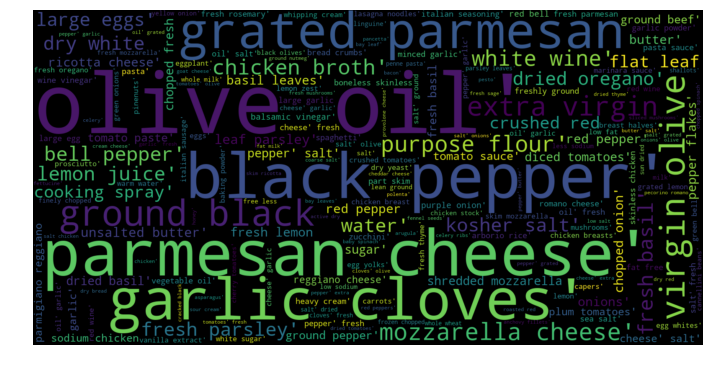

In [126]:
italian_ingr = train_data.loc[train_data.cuisine == 'italian',['ingredients']]

italian_ingr_word_cloud = [] # this list stores all the ingredients in all recipes (with duplicates)
for item in italian_ingr['ingredients']:
    for ingr in item:
        italian_ingr_word_cloud.append(ingr) 
        
wordCloud = str(ingredients)

from wordcloud import WordCloud
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(wordCloud)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

From the box plots of recipe length distributions, we can make several observations: 

* the Moroccan cuisine seems to have the longest recipes on average compared to all the rest cuisines in our sample;
* we observe the opposite phenomenon for the Irish, British, French and Southern_us cuisine;
* there exist outliers in all cuisines (in some of them - many);
* most of the Asian cuisines (Vietnamese, Thai, Indian) turn out to have larger recipes on average than most of the rest cuisines which means that our guess in Take a closer look at the extremes about their length in not accurate;
* recipes part of the European cuisine tend to be with average length or shorter compared to the rest of the sample.

Which are the most common ingredients in the whole training sample? How many unique ingredients can we find in the dataset? 

In [25]:
allingredients = [] # this list stores all the ingredients in all recipes (with duplicates)
for item in train_data['ingredients']:
    for ingr in item:
        allingredients.append(ingr) 

In [26]:
# Count how many times each ingredient occurs
countingr = Counter()
for ingr in allingredients:
     countingr[ingr] += 1

In [27]:
print("The most commonly used ingredients (with counts) are:")
print("\n")
print(countingr.most_common(20))
print("\n")
print("The number of unique ingredients in our training sample is {}.".format(len(countingr)))

The most commonly used ingredients (with counts) are:


[('salt', 18049), ('onions', 7972), ('olive oil', 7972), ('water', 7457), ('garlic', 7380), ('sugar', 6434), ('garlic cloves', 6237), ('butter', 4848), ('ground black pepper', 4785), ('all-purpose flour', 4632), ('pepper', 4438), ('vegetable oil', 4385), ('eggs', 3388), ('soy sauce', 3296), ('kosher salt', 3113), ('green onions', 3078), ('tomatoes', 3058), ('large eggs', 2948), ('carrots', 2814), ('unsalted butter', 2782)]


The number of unique ingredients in our training sample is 6714.


In [28]:
# Extract the first 20 most common ingredients in order to vizualize them for better understanding
mostcommon = countingr.most_common(20)
mostcommoningr = [i[0] for i in mostcommon]
mostcommoningr_count = [i[1] for i in mostcommon]

In [29]:
# trace = go.Bar(
#             x=mostcommoningr_count[::-1],
#             y= mostcommoningr[::-1],
#             orientation = 'h',marker = dict(color = random_colours(20),
# ))
# layout = go.Layout(
#     xaxis = dict(title= 'Number of occurences in all recipes (training sample)', ),
#     yaxis = dict(title='Ingredient',),
#     title= '20 Most Common Ingredients', titlefont = dict(size = 20),
#     margin=dict(l=150,r=10,b=60,t=60,pad=5),
#     width=800, height=500, 
# )
# data = [trace]
# fig = go.Figure(data=data, layout=layout)
# iplot(fig, filename='horizontal-bar')

It seems that salt is the most commonly used ingredient which is not surprising at all! We also find water, onions, garlic and olive oil - not so surprising also. :) 
Salt is such a common ingredient that we expect it to have poor predictive power in recognizing the type of cuisine.

Explore how many different ingredients can be found in each cuisine

In [30]:
# Define a function that returns how many different ingredients can be found in all recipes part of a given cuisine
def findnumingr(cuisine):
    '''
    Input:
        cuisine - cuisine category (ex. greek,souther_us etc.)
    Output:
        The number of unique ingredients used in all recipes part of the given cuisine. 
    '''
    listofinrg = []
    for item in train_data[train_data['cuisine'] == cuisine]['ingredients']:
        for ingr in item:
            listofinrg.append(ingr)
    result = (cuisine,len(list(set(listofinrg))))         
    return result 

In [34]:
cuisineallingr = []
for i in labels:
    cuisineallingr.append(findnumingr(i))

In [36]:
# # Vizualize the results
# trace = go.Bar(
#             x=[i[1] for i in cuisineallingr],
#             y= [i[0] for i in cuisineallingr],
#             orientation = 'h',marker = dict(color = random_colours(20),
# ))
# layout = go.Layout(
#     xaxis = dict(title= 'Count of different ingredients', ),
#     yaxis = dict(title='Cuisine',),
#     title= 'Number of all the different ingredients used in a given cuisine', titlefont = dict(size = 20),
#     margin=dict(l=100,r=10,b=60,t=60),
#     width=800, height=500, 
# )
# data = [trace]
# fig = go.Figure(data=data, layout=layout)
# iplot(fig, filename='horizontal-bar')

From the above bar chart, we can see that it is not necessary that cuisines with more instances in the training sample should be associated with more ingredients representing them. It turns out that the French cuisine which is 6,65% of the training sample has more variability in ingredients than the Indian cuisine (this observation is unexpected since Indians use many spices in their recipes - Wiki-Indian cuisine ).

Explore which ingredients occur only in one cuisine (ingredients specific to the cuisine)

In [37]:
allingredients = list(set(allingredients)) # list containing all unique ingredients

In [39]:
len(allingredients)

6714

In [40]:
# Define a function that returns a dataframe with top unique ingredients in a given cuisine 
def cuisine_unique(cuisine,numingr, allingredients):
    '''
    Input:
        cuisine - cuisine category (ex. 'brazilian');
        numingr - how many specific ingredients do you want to see in the final result; 
        allingredients - list containing all unique ingredients in the whole sample.
    
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in train_data[train_data.cuisine != cuisine]['ingredients']:
        for ingr in item:
            allother .append(ingr)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in allingredients if x not in allother]
    
    mycounter = Counter()
    
    for item in train_data[train_data.cuisine == cuisine]['ingredients']:
        for ingr in item:
            mycounter[ingr] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    cuisinespec = pd.DataFrame(mycounter.most_common(numingr), columns = ['ingredient','count'])
    
    return cuisinespec


In [41]:
cuisinespec= cuisine_unique('mexican', 10, allingredients)
print("The top 10 unique ingredients in Mexican cuisine are:")
cuisinespec 

The top 10 unique ingredients in Mexican cuisine are:


,ingredient,count
0,refried beans,250
1,taco seasoning mix,181
2,red enchilada sauce,65
3,taco sauce,63
4,poblano chilies,33
5,mexican chocolate,32
6,baked tortilla chips,31
7,green enchilada sauce,31
8,Mexican beer,30
9,chipotle,25


Now let's make some vizualizations of our findings about the "special" ingredients 

In [43]:
# # Vizualization of specific ingredients in the first 10 cuisines
# labels = [i for i in train_data.cuisine.value_counts().index][0:10]
# totalPlot = 10
# y = [[item]*2 for item in range(1,10)]
# y = list(chain.from_iterable(y))
# z = [1,2]*int((totalPlot/2))

# fig = tools.make_subplots(rows= 5, cols=2, subplot_titles= labels, specs = [[{}, {}],[{}, {}],[{}, {}],[{}, {}],[{}, {}]],  horizontal_spacing = 0.20)
# traces = []
# for i,e in enumerate(labels): 
#     cuisinespec= cuisine_unique(e, 5, allingredients)
#     trace = go.Bar(
#             x= cuisinespec['count'].values[::-1],
#             y=  cuisinespec['ingredient'].values[::-1],
#             orientation = 'h',marker = dict(color = random_colours(5),))
#     traces.append(trace)

# for t,y,z in zip(traces,y,z):
#     fig.append_trace(t, y,z)

#     fig['layout'].update(height=800, width=840,
#     margin=dict(l=265,r=5,b=40,t=90,pad=5), showlegend=False, title='Ingredients used only in one cuisine')

# iplot(fig, filename='horizontal-bar')

In [45]:
# # Vizualization of specific ingredients in the second 10 cuisines
# labels = [i for i in train_data.cuisine.value_counts().index][10:20]
# totalPlot = 10
# y = [[item]*2 for item in range(1,10)]
# y = list(chain.from_iterable(y))
# z = [1,2]*int((totalPlot/2))

# fig = tools.make_subplots(rows= 5, cols=2, subplot_titles= labels, specs = [[{}, {}],[{}, {}],[{}, {}],[{}, {}],[{}, {}]],  horizontal_spacing = 0.20)
# traces = []
# for i,e in enumerate(labels): 
#     cuisinespec= cuisine_unique(e, 5, allingredients)
#     trace = go.Bar(
#             x= cuisinespec['count'].values[::-1],
#             y=  cuisinespec['ingredient'].values[::-1],
#             orientation = 'h',marker = dict(color = random_colours(5),))
#     traces.append(trace)

# for t,y,z in zip(traces,y,z):
#     fig.append_trace(t, y,z)

#     fig['layout'].update(height=800, width=840,
#     margin=dict(l=170,r=5,b=40,t=90,pad=5), showlegend=False, title='Ingredient used only in one cuisine')

# iplot(fig, filename='horizontal-bar')

From the two vizualizations above we can make several observations: 

* the Mexican cuisine is the only one where we find that the unique ingredients are also found in many recipes part of the cuisine in question. The refried beans are found more than 200 times in Mexican recipes (250 out of 6438 recipes ~ 4% of all Mexican recipes). This finding means that the 'refried beans' and 'taco' (or derivatives of those) ingredients are expected to be strong predictors of Mexican cuisine. On the next step of the analysis we will try to support this observation by using Tf-Idf representation of our training sample in an attempt to find the most important ingredients in a cuisine.
* the above-mentioned observation is also valid for the:
    * the Italian gnocchi - Wikipedia - Gnocchi;
    * Brazilian cuisine with its traditional cachaca which is the most popular spirit among distilled alcoholic beverage in Brazil (or at least according to Wikipedia - Cachaca).
    * Indian fenugreek - in our sample it is found only in the Indian cuisine which is surprising since it can be found in the whole Asian region Wikipedia - Fenugreek) and also because in my home-country (Bulgaria) we also use it a lot which means that it is not specific only to the Asian region. :)

Find the most important ingredients in each cuisine using Tf-Idf transformation

* Tf-Idf measure will simply point out which are the features (words) that are important for a given cuisine. To put it simply - these will be ingredients that are frequently used in the recipes belonging to that cuisine and at the same time not so frequently used in the whole sample of recipes. 

* Higher tf-idf score means higher importance of the word for the given cuisine and the opposite (for more information on the measure and how it is calculated:Tf-Idf ). 

* The result of the Tf-Idf transformation of our dataset is a matrix of tf-idf scores with one row per recipe and as many columns as there are different ingredients in the dataset.

In [47]:
# Prepare the data 
features = [] # list of list containg the recipes
for item in train_data['ingredients']:
    features.append(item)

In [49]:
len(features)

39774

In [50]:
ingredients = [] # this list stores all the ingredients in all recipes (with duplicates)
for item in train_data['ingredients']:
    for ingr in item:
        ingredients.append(ingr) 

In [51]:
len(features) # 39774 recipes

39774

In [52]:
len(ingredients)

428275

In [53]:
# Fit the TfidfVectorizer to data
tfidf = TfidfVectorizer(vocabulary= list(set([str(i).lower() for i in ingredients])), max_df=0.99, norm='l2', ngram_range=(1, 4))
X_tr = tfidf.fit_transform([str(i) for i in features]) # X_tr - matrix of tf-idf scores
feature_names = tfidf.get_feature_names()

Important Note: For the Tf-Idf representation we are using as vocabulary the ingredients as they are given in the data - no unigrams or bigrams are extracted at this stage. Also bear in mind that the data is not processed/cleaned.

In [57]:
# Define a function for finding the most important features in a given cuisine according to Tf-Idf measure 
def top_feats_by_class(trainsample,target,featurenames, min_tfidf=0.1, top_n=10):
    ''' 
     Input:
         trainsample - the tf-idf transformed training sample;
         target - the target variable;
         featurenames - array mapping from feature integer indices (position in the dataset) to feature name (ingredient in our case) in the Tf-Idf transformed dataset; 
         min_tfidf - features having tf-idf value below the min_tfidf will be excluded ;
         top_n - how many important features to show.
     Output:
          Returns a list of dataframe objects, where each dataframe holds top_n features and their mean tfidf value
         calculated across documents (recipes) with the same class label (cuisine). 
     '''
    dfs = []
    labels = np.unique(target)
    
    for label in labels:
        
        ids = np.where(target==label)
        D = trainsample[ids].toarray()
        D[D < min_tfidf] = 0
        tfidf_means = np.nanmean(D, axis=0)
        
        topn_ids = np.argsort(tfidf_means)[::-1][:top_n] #  Get top n tfidf values
        top_feats = [(featurenames[i], tfidf_means[i]) for i in topn_ids] # find their corresponding feature names
        df = pd.DataFrame(top_feats)
        df.columns = ['feature', 'tfidf']
        
        df['cuisine'] = label
        dfs.append(df)
        
    return dfs


In [58]:
# Extract the target variable
target = train_data['cuisine']

In [59]:
result_tfidf = top_feats_by_class(X_tr, target, feature_names, min_tfidf=0.1, top_n=5)

Vizualizations of Important Features according to Tf-Idf measure

In [61]:
# # Exctract labels from the resulting dataframe
# labels = []
# for i, e in enumerate(result_tfidf):
#     labels.append(result_tfidf[i].cuisine[0])

# # Set the plot
# totalPlot = 10
# y = [[item]*2 for item in range(1,10)]
# y = list(chain.from_iterable(y))
# z = [1,2]*int((totalPlot/2))

# fig = tools.make_subplots(rows= 5, cols=2, subplot_titles= labels[0:10], specs = [[{}, {}],[{}, {}],[{}, {}],[{}, {}],[{}, {}]],  horizontal_spacing = 0.20)
# traces = []
# for index,element in enumerate(result_tfidf[0:10]): 
#     trace = go.Bar(
#             x= result_tfidf[index].tfidf[::-1],
#             y= result_tfidf[index].feature[::-1],
#             orientation = 'h',marker = dict(color = random_colours(5),))
#     traces.append(trace)

# for t,y,z in zip(traces,y,z):
#     fig.append_trace(t, y,z)

#     fig['layout'].update(height=800, width=840,
#     margin=dict(l=110,r=5,b=40,t=90,pad=5), showlegend=False, title='Feature Importance based on Tf-Idf measure')

# iplot(fig, filename='horizontal-bar')

In [63]:
# # Set the plot
# totalPlot = 10
# y = [[item]*2 for item in range(1,10)]
# y = list(chain.from_iterable(y))
# z = [1,2]*int((totalPlot/2))

# fig = tools.make_subplots(rows= 5, cols=2, subplot_titles= labels[10:20], specs = [[{}, {}],[{}, {}],[{}, {}],[{}, {}],[{}, {}]],  horizontal_spacing = 0.20)
# traces = []
# for index,element in enumerate(result_tfidf[10:20]): 
#     trace = go.Bar(
#             x= result_tfidf[10:20][index].tfidf[::-1],
#             y= result_tfidf[10:20][index].feature[::-1],
#             orientation = 'h',marker = dict(color = random_colours(5),))
#     traces.append(trace)

# for t,y,z in zip(traces,y,z):
#     fig.append_trace(t, y,z)

#     fig['layout'].update(height=800, width=840,
#     margin=dict(l=100,r=5,b=40,t=90,pad=5), showlegend=False, title='Feature Importance based on Tf-Idf measure')

# iplot(fig, filename='horizontal-bar')

From the vizualizations above we can make the following observations: 

* several of our assumptions in this section of the analysis were accurate - cachaca is major ingredient in Brazilian recipes and tortillas are important in Mexican cuisine.
* some of the important words appear in several cuisines, BUT still this observation holds true only if the cuisines are in the same region:
    * In Asian cuisines we find that fish, sauce, soy and sesame are all with higher tf-idf values;
    * butter, sugar, eggs and flour are found in several European cuisines;
    * Greek, Spanish and Italian cuisines all share olive oil and cheese.
* another observation we can make is that different spices (rather than food like fruits, vegetables, fish or meat) dominate the Moroccan, Indian and Jamaican cuisines.

# <div align="center">II.What's Cooking? - Text Processing</div>
---------------------------------------------------------------------

We will proceed the analysis by performing some simple data processing. The aim is to prepare the data for model development.

Prepare the train and test samples for model development

In [64]:
# Train sample 
print("How training data looks like at this stage (example of one recipe):")
print(str(features[0]) + '\n' )
print("Number of instances: "+ str(len(features)) + '\n')
print("And the target variable:")
print(target[0])

How training data looks like at this stage (example of one recipe):
['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']

Number of instances: 39774

And the target variable:
greek


In [65]:
# Test Sample - only features - the target variable is not provided.
features_test = [] # list of lists containg the recipes
for item in test_data['ingredients']:
    features_test.append(item)

In [66]:
print("How test data looks like at this stage (example of one recipe):")
print(str(features_test[0]) + '\n')
print("Number of instances: "+ str(len(features_test)))

How test data looks like at this stage (example of one recipe):
['baking powder', 'eggs', 'all-purpose flour', 'raisins', 'milk', 'white sugar']

Number of instances: 9944


In [67]:
# Both train and test samples are processed in the exact same way
# Train
features_processed= [] # here we will store the preprocessed training features
for item in features:
    newitem = []
    for ingr in item:
        ingr.lower() # Case Normalization - convert all to lower case 
        ingr = re.sub("[^a-zA-Z]"," ",ingr) # Remove punctuation, digits or special characters 
        ingr = re.sub((r'\b(oz|ounc|ounce|pound|lb|inch|inches|kg|to)\b'), ' ', ingr) # Remove different units  
        newitem.append(ingr)
    features_processed.append(newitem)

# Test 
features_test_processed= [] 
for item in features_test:
    newitem = []
    for ingr in item:
        ingr.lower() 
        ingr = re.sub("[^a-zA-Z]"," ",ingr)
        ingr = re.sub((r'\b(oz|ounc|ounce|pound|lb|inch|inches|kg|to)\b'), ' ', ingr) 
        newitem.append(ingr)
    features_test_processed.append(newitem) 

In [69]:
len(features_processed)

39774

In [51]:
# Check for empty instances in train and test samples after processing before proceeding to next stage of the analysis    
count_m = []    
for recipe in features_processed:
    if not recipe:
        count_m.append([recipe])
    else: pass
print("Empty instances in the preprocessed training sample: " + str(len(count_m)))

Empty instances in the preprocessed training sample: 0


In [52]:
count_m = []    
for recipe in features_test_processed:
    if not recipe:
        count_m.append([recipe])
    else: pass
print("Empty instances in the preprocessed test sample: " + str(len(count_m))) 

Empty instances in the preprocessed test sample: 0


In [71]:
len(features_processed)

39774

In [77]:
# allingredients = [] # this list stores all the ingredients in all recipes (with duplicates)
# for item in features_processed:
#     for ingr in item:
#         allingredients.append(ingr) 

# Count how many times each ingredient occurs
# countingr = Counter()
# for ingr in allingredients:
#      countingr[ingr] += 1
        
allingredients = list(set(allingredients)) # list containing all unique ingredients

len(allingredients)


6709

Now the data is prepared for building a prediction model based on ingredients. At this step of the analysis we made some simple but important transformations on the data:

* Case normalization - all words are converted to lower case;
* Removal of punctuation, digits or special characters - they are not considered as informative and correlated with the problem;
* Removal of different units measuring the ingredients - they can also be considered as not so related to the problem at hand and therefore can be excluded from further analysis. 

Performing this simple manipulation on data can give us confidence that a significant amount of 'noise' in our data is removed which is likely to lead to better results during the data modeling stage.

# <div align="center">III. What's Cooking? - Feature Engineering & Data Modeling</div>
---------------------------------------------------------------------

1) Feature engineering

In [79]:
# # Binary representation of the training set will be employed
# vectorizer = CountVectorizer(analyzer = "word",
#                              ngram_range = (1,1), # unigrams
#                              binary = True, #  (the default is counts)
#                              tokenizer = None,    
#                              preprocessor = None, 
#                              stop_words = None,  
#                              max_df = 0.99) # any word appearing in more than 99% of the sample will be discarded

In [86]:
vectorizer2 = CountVectorizer(analyzer = "word",
                             ngram_range = (1,1), # unigrams
                             binary = True, #  (the default is counts)
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None) # any word appearing in more than 99% of the sample will be discarded

In [87]:
# Fit the vectorizer on the training data and transform the test sample
train_X = vectorizer2.fit_transform([str(i) for i in features_processed])
test_X =  vectorizer2.transform([str(i) for i in features_test_processed])

In [88]:
train_X.toarray().shape

(39774, 2996)

In [89]:
test_X.toarray().shape

(9944, 2996)

During the feature engineering stage we transform the textual data into more suitable format for performing mathematical operations and statistical learning techniques. In other words - we turn text into numbers.

We choose to use binary representation which is very simple to understand and implement. Also for simplicity we choose to use only unigrams for building the prediction model. This means that in model development will be included features consisting of single words only. This can be considered as a good baseline and starting point for further analysis. 

Finally, we exclude words appearing in more than 99% of our training instances because they can't be considered as good differentiators of data.

2) Model Development

In [90]:
# Apply label encoding on the target variable (before model development)
lb = LabelEncoder()
train_Y = lb.fit_transform(target)

In [91]:
np.unique(train_Y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [56]:
# Ensemble Unigram model (baseline model) - parameters are not tuned at this stage
vclf=VotingClassifier(estimators=[('clf1',LogisticRegression(random_state = 42)),
                                  ('clf2',SVC(kernel='linear',random_state = 42,probability=True)),
                                  ('clf3',RandomForestClassifier(n_estimators = 600,random_state = 42))], 
                                    voting='soft', weights = [1,1,1]) 
vclf.fit(train_X, train_Y)

VotingClassifier(estimators=[('clf1', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('clf2', SVC(C=...ators=600, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft',
         weights=[1, 1, 1])

In [57]:
# # 10-fold Cross validation of  the results
# kfold = model_selection.KFold(n_splits=10, random_state=42)
# valscores = model_selection.cross_val_score(vclf, train_X, train_Y, cv=kfold)
# print('Mean accuracy on 10-fold cross validation: ' + str(np.mean(valscores))) #  0.8005731359034913

In [58]:
# Generate predictions on test sample
predictions = vclf.predict(test_X) 
predictions = lb.inverse_transform(predictions)
predictions_final = pd.DataFrame({'cuisine' : predictions , 'id' : test_data.id }, columns=['id', 'cuisine'])
predictions_final.to_csv('Final_submission.csv', index = False)

Our first attempt to describe the data and build a prediction model of the cuisine consists of creating a Unigram Ensemble model which combines the decisions of the following three classifiers:

* Logistic Regression;
* Linear Support Vector Classifier;
* Random Forest.

Predictions generated by the three classifiers are given equal weights in the final prediction. No hyperparameter tuning is applied at this stage which can be considered as a future opportunity for improvement of the predictive power of the model. 

Also, the baseline model can be improved by using bigrams or higher order features (n-grams). Our baseline model is validated via 10-fold cross validation and the measured average accuracy on train sample is 80,05%. 

Considering the results and the fact that we are using only unigrams (~3000 features only) and machine learning models are not tuned - this is a pretty good baseline model. Indeed, good cooking (and analyzing) lies in simplicity.